In [1]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Printf,
    Plots,

    Random,
    StatsBase
;

using Distributions, Interpolations

import MutableNamedTuples: MutableNamedTuple
import StructArrays: StructArray, StructVector
import StaticArrays: @SVector, SVector
import LinearAlgebra: norm, ⋅, adjoint!, diag
import LoopVectorization: @turbo
using BenchmarkTools
using Parameters
using LsqFit

import ProgressMeter: Progress, next!

const λ = 626e-9
const Γ = 2π* 6.4e6
const m = @with_unit 57 "u"
const k = 2π / λ
_μB = (μ_B / h) * 1e-4;

include("CaOH_scan_helper_constant_diffusion.jl")
include("CaOH_scan_helper_diffusion.jl")
working_dir = "G:\\My Drive\\github\\OpticalBlochEquations\\examples\\ipynb_sources\\toy_models\\CaOH_scan"
# working_dir = "C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\repump"
;

In [2]:
package = get_CaOH_package();
package_A = get_CaOH_package_12_A_states();
n_states = length(package.states)
n_excited = package.n_excited;

In [3]:
using MAT

size_file_path = "X:\\Shared drives\\CaOH exp\\Papers\\CaOH_BlueMOT\\Analysis\\Figure2\\F1IntensityScan_20240124\\intensity.mat"
size_file = matread(size_file_path);

numbers_file_path = "X:\\Shared drives\\CaOH exp\\Papers\\CaOH_BlueMOT\\Analysis\\Figure2\\F1IntensityScan_20240124\\intensity_numbers.mat"
numbers_file = matread(numbers_file_path);
 
temperature_file_path = "X:\\Shared drives\\CaOH exp\\Papers\\CaOH_BlueMOT\\Analysis\\Figure2\\F1IntensityScan_Temperature_20240131\\temperatures.mat"
temperature_file = matread(temperature_file_path);

simulation_file_path = "X:\\Shared drives\\CaOH exp\\Papers\\CaOH_BlueMOT\\Analysis\\Figure2\\F1IntensityScan_20240124\\simulations_diffusion.mat";

In [4]:
widths_x = size_file["widths_x"];
d_widths_x = size_file["widths_errors_x"];
widths_y = size_file["widths_y"];
d_widths_y = size_file["widths_errors_y"];

data_size = (widths_x.^2 .* widths_y).^(1/3)
d_data_size = sqrt.((2/3 .* d_widths_x ./ widths_x).^2 + (1/3 .* d_widths_y ./ widths_y).^2) .* data_size

data_signal = numbers_file["ampx1"];
d_data_signal = numbers_file["ampx1_errors"];

data_temperature = real.(temperature_file["temps"]);
d_data_temperature = real.(temperature_file["temp_errors"]);

voltages = size_file["all_params"]'

12×1 adjoint(::Matrix{Float64}) with eltype Float64:
    0.0
  100.0
  200.0
  300.0
  400.0
  500.0
  600.0
  700.0
  800.0
  900.0
 1000.0
 1100.0

In [5]:
saving_path = "C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\parameter_scans\\scan_intensity_ratio_diffusion1000.jl"

"C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\parameter_scans\\scan_intensity_ratio_diffusion1000.jl"

In [7]:
function find_diffusion_constant(params; run_time=1e-3, n_particles=20, ramp_time=1e-6, temp=1e-4, diameter=80e-6)
    params_copy = deepcopy(params)
    params_copy.n_values = n_particles
    params_copy.B_ramp_time = ramp_time
    params_copy.s_ramp_time = ramp_time
    params_copy.temp = temp
    params_copy.diameter = diameter
    sequence = [params_copy]
    durations = [run_time]
    generate_sequence!(sequence, durations)
    
    results = simulate_particles_diffusion(package, package_A, sequence, variable_budget=true)
    diffusion_constant = plot_average_diffusion(results)
    return diffusion_constant
end

find_diffusion_constant (generic function with 1 method)

In [8]:
function get_Δ_from_exp(voltage, aom1_freq, aom2_freq)
    # return Δ1, Δ2 in MHz
    Δ1 = 52 - 7.4*(5.5-voltage)
    Δ2 = Δ1 + 51.24 - aom1_freq
    Δ4 = Δ1 + 51.24 - aom2_freq
    return Δ1, Δ2, Δ4
end

temp = @with_unit 1.00 "mK"
diameter = @with_unit 0.6 "mm"
displacement = [0., 0., 0.]*1e-3
kick = [0.0, 0.0, 0.0]
 

s2 = 0.0; Δ2 = 0.0; B_gradient = 75; ramp_time = 4e-3

detuning_voltage = -0.5
aom1_freq = 53.75
aom2_freq = 52
Δ1, Δ3, Δ4 = get_Δ_from_exp(detuning_voltage, aom1_freq, aom2_freq).*(1e6*2π)

intensity_voltage = 0.9
power_total = intensity_voltage * 13.1/2.2 # mW

p1 = 3.7/(3.7 + 2.8 + 3.5) * power_total
p3 = 2.8/(3.7 + 2.8 + 3.5) * power_total
p4 = 3.5/(3.7 + 2.8 + 3.5) * power_total

s1 = 2 * p1 / (π * 0.5^2) / 3.4
s3 = 2 * p3 / (π * 0.5^2) / 3.4
s4 = 2 * p4 / (π * 0.5^2) / 3.4

s_total = s1 + s3 + s4
ratio_1 = s1 / (s1 + s3)
ratio_3 = s3 / (s1 + s3)
;


results_list = []

for ratio_voltage in voltages
    
    ratio = ratio_voltage / 1100 * 0.8 
    s4 = ratio / (1+ratio) * s_total
    s1 = (s_total - s4) * ratio_1
    s3 = (s_total - s4) * ratio_3
    println(s1)
    println(s3)
    println(s4)
    
    @printf("aom voltage = %.1f V", ratio_voltage)
    println()
    @printf("ratio = %.1f", s4 / (s1 + s3))

    blue_MOT_params = MutableNamedTuple(t_start = 0.0, t_end = 5e-3, n_values = 1000,
                                pol1_x=σ⁻, pol2_x=σ⁻, pol3_x=σ⁺, pol4_x=σ⁻, 
                                s1=s1, s2=s2, s3=s3, s4=s4,
                                Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4, 
                                B_gradient = B_gradient, 
                                B_ramp_time = ramp_time,
                                Bz_offset = 0.0, By_offset = 0.0, Bx_offset=0.0,

                                temp=temp, diameter=diameter, 
                                displacement=displacement, kick=kick,
                                s_ramp_time = ramp_time,
                                s_ramp_to_factor = 7/9,

                                photon_budget=Inf, dark_lifetime=1/(0.7e6)*Γ, FC_mainline=1,
                                pol_imbalance=0.0, 
                                s_imbalance = (0., 0., -0.), retro_loss=0.0, 

                                off_center=[0, -0, -0, 0, 0, 0].*1e-3, 
                                pointing_error =[0.0, 0.0, 0.0,0.0,0,0],

                                ODT_intensity = 13.3*1e3/(50e-4)^2*0,
                                ODT_size = (30e-6, 2e-3, 30e-6), 
                                ODT_revolutions = 3,
                                ODT_rmax = 100e-6, # distance of radial motion
                                ODT_tmax = 30e-3, # timescale of radial motion
                                ODT_motion_t_start = 30e-3,
                                ODT_motion_t_stop = 50e-3,

                                dt = 1e-2,
                                diffusion_constant = 0.0)

    # Find diffusion constant for the current parameters
    diffusion_constant = find_diffusion_constant(blue_MOT_params, run_time=1e-3, n_particles=20, 
                                            ramp_time=1e-6, temp = 1e-4, diameter=80e-6)

    blue_MOT_params.diffusion_constant = diffusion_constant
    @printf("Diffusion constant = %.2f \n", diffusion_constant)
    sequence = [blue_MOT_params]
    durations = [ramp_time + 1e-3]
    generate_sequence!(sequence, durations)

    @time results = simulate_particles_constant_diffusion(package, package_A, sequence, variable_budget=true);
    
    push!(results_list, results)
    
    serialize(saving_path, results_list)

    @printf("goodness = %.2f",  goodness(blue_MOT_params.t_end, results))
    
    println()
    println()
end

2.284760537226738
1.729007974117531
0.0
aom voltage = 0.0 V
ratio = 0.0

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\halla\.julia\packages\SciMLBase\szsYq\src\integrator_interface.jl:606
Progress:  40%|█████████████████                        |  ETA: 0:07:19┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\halla\.julia\packages\SciMLBase\szsYq\src\integrator_interface.jl:606
Progress: 100%|█████████████████████████████████████████| Time: 0:09:32


Diffusion constant = 1.75 


1457.093315 seconds (12.14 M allocations: 999.747 MiB, 0.02% gc time, 20.42% compilation time)


Progress: 100%|█████████████████████████████████████████| Time: 0:24:16


Survival: 454 / 1000
goodness = 0.07

2.129861517753739
1.6117870945163426
0.27211989907418777
aom voltage = 100.0 V
ratio = 0.1

Progress: 100%|█████████████████████████████████████████| Time: 0:06:36


Diffusion constant = 1.53 


Progress: 100%|█████████████████████████████████████████| Time: 0:30:28


1828.539278 seconds (1.71 M allocations: 342.175 MiB)
Survival: 692 / 1000
goodness = 0.25

1.9946322150392157
1.5094514059756223
0.5096848903294311
aom voltage = 200.0 V
ratio = 0.1

Progress: 100%|█████████████████████████████████████████| Time: 0:06:23


Diffusion constant = 1.44 


Progress: 100%|█████████████████████████████████████████| Time: 0:33:13


1993.171172 seconds (1.72 M allocations: 345.260 MiB)
Survival: 802 / 1000
goodness = 0.37

1.8755496947383672
1.4193349041263315
0.7188839124795705
aom voltage = 300.0 V
ratio = 0.2

Progress: 100%|█████████████████████████████████████████| Time: 0:05:43


Diffusion constant = 1.40 


Progress: 100%|█████████████████████████████████████████| Time: 0:35:12


2112.455691 seconds (1.73 M allocations: 347.352 MiB, 0.00% gc time)
Survival: 868 / 1000
goodness = 0.44

1.7698849232038112
1.3393723743163974
0.9045112138240606
aom voltage = 400.0 V
ratio = 0.3

Progress: 100%|█████████████████████████████████████████| Time: 0:06:23


Diffusion constant = 1.34 


Progress: 100%|█████████████████████████████████████████| Time: 0:33:53


2033.232900 seconds (1.72 M allocations: 346.642 MiB)
Survival: 883 / 1000
goodness = 0.47

1.6754910606329412
1.2679391810195226
1.0703382696918051
aom voltage = 500.0 V
ratio = 0.4

Progress: 100%|█████████████████████████████████████████| Time: 0:04:09


Diffusion constant = 1.31 


Progress: 100%|█████████████████████████████████████████| Time: 0:23:29


1409.064846 seconds (1.71 M allocations: 346.416 MiB)
Survival: 883 / 1000
goodness = 0.48

1.5906560702211467
1.2037397288160026
1.2193727123071196
aom voltage = 600.0 V
ratio = 0.4

Progress: 100%|█████████████████████████████████████████| Time: 0:03:56


Diffusion constant = 1.29 


Progress: 100%|█████████████████████████████████████████| Time: 0:23:47


1427.994892 seconds (1.71 M allocations: 346.832 MiB)
Survival: 899 / 1000
goodness = 0.50

1.5139979463550675
1.1457281756200508
1.354042389369151
aom voltage = 700.0 V
ratio = 0.5

Progress: 100%|█████████████████████████████████████████| Time: 0:04:00


Diffusion constant = 1.26 


Progress: 100%|█████████████████████████████████████████| Time: 0:23:09


1389.909826 seconds (1.70 M allocations: 346.580 MiB, 0.00% gc time)
Survival: 905 / 1000
goodness = 0.51

1.4443888453732252
1.0930510181202784
1.4763286478507656
aom voltage = 800.0 V
ratio = 0.6

Progress: 100%|█████████████████████████████████████████| Time: 0:04:09


Diffusion constant = 1.22 


Progress: 100%|█████████████████████████████████████████| Time: 0:21:43                                                                   


1303.435847 seconds (1.70 M allocations: 346.693 MiB)
Survival: 923 / 1000
goodness = 0.53

1.3808992257963801
1.0450048195215846
1.5878644660263044
aom voltage = 900.0 V
ratio = 0.7

Progress: 100%|█████████████████████████████████████████| Time: 0:03:13


Diffusion constant = 1.23 


Progress: 100%|█████████████████████████████████████████| Time: 0:13:10


790.030198 seconds (1.65 M allocations: 343.040 MiB, 0.00% gc time)
Survival: 905 / 1000
goodness = 0.51

1.3227561004996904
1.00100461659436
1.6900077942502185
aom voltage = 1000.0 V
ratio = 0.7

Progress: 100%|█████████████████████████████████████████| Time: 0:03:12


Diffusion constant = 1.22 


Progress: 100%|█████████████████████████████████████████| Time: 0:13:17


797.581277 seconds (1.64 M allocations: 342.913 MiB, 0.00% gc time)
Survival: 921 / 1000
goodness = 0.53

1.2693114095704099
0.9605599856208505
1.7838971161530086
aom voltage = 1100.0 V
ratio = 0.8

Progress: 100%|█████████████████████████████████████████| Time: 0:03:14
Progress:   3%|██                                       |  ETA: 0:18:09

Diffusion constant = 1.20 


Progress: 100%|█████████████████████████████████████████| Time: 0:13:41


821.922154 seconds (1.65 M allocations: 343.512 MiB)
Survival: 940 / 1000
goodness = 0.54



0.05261990612063662
0.12633685679175477


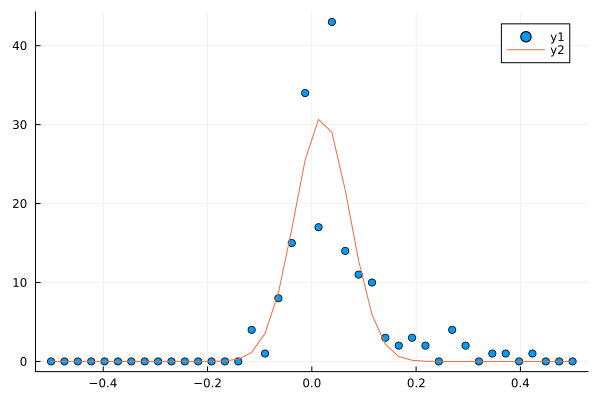

In [50]:
n_values = 200
results = results_list[1]
t_end = 5e-3

sizes = []
x_grid = collect(LinRange(-0.5, 0.5, 40))

results1 = bootstrap_iteration(results, n_values=n_values)

id_survived = survived(t_end, results1.times)

xs = [results1.x_trajectories[j][end] for j in id_survived]
density_x = distribution_to_func(x_grid, xs)


p0 = [10, 0.1,0.0]
fit = curve_fit(gaussian, x_grid, density_x, p0);
k_B = 1.38e-23

println(fit.param[2])
println(plot_size(results1, "x")[2][end])
#     println(m * fit.param[2]^2 /k_B *1e6)

# println(plot_temperature(results1, "x")[2][end])
scatter(x_grid, density_x)
plot!(x_grid, gaussian(x_grid, fit.param))

In [51]:
results = results_list[1]
size, error = bootstrap_size_fit(results; iter=100)
size

0.04433439801061881

In [52]:
signal, error = bootstrap_survival(results, iter=100)
signal

0.5624158508076152

In [53]:
temp, error = bootstrap_temperature_fit(results, iter=100, range=1, n_grids=20)
temp

89.0530170006897

In [55]:
factorial(5)

120

In [10]:
# serialize("C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\parameter_scans\\scan_single_det2000.jl", results_list)

In [12]:
results_list = deserialize("C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\parameter_scans\\scan_intensity_ratio2000.jl");
results_list_imperfection = deserialize("C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\parameter_scans\\scan_intensity_ratio_imperfection2000.jl")
results_list_imperfection1 = deserialize("C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\parameter_scans\\scan_intensity_ratio_imperfection_repump200.jl");

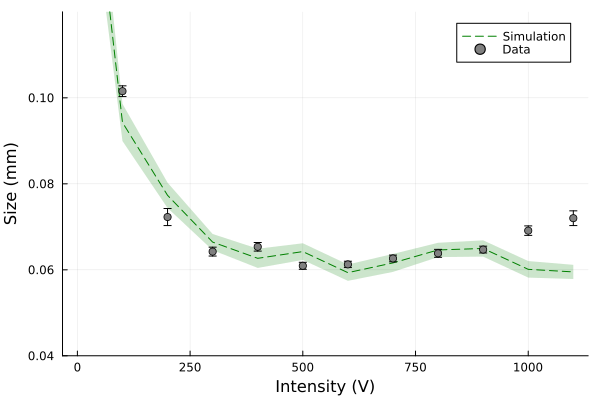

In [9]:
sizes = []
size_errors = []
for results in results_list[1:end]
    size, error = bootstrap_size_fit(results; iter=100)
    push!(sizes, size)
    push!(size_errors, error)
end

plot(voltages, sizes,color="green",linestyle=:dash, xlabel="Intensity (V)", ylabel="Size (mm)",label="Simulation",
ribbon=(size_errors, size_errors),fc=:green,fa=0.2)

# sizes1 = []
# size1_errors = []
# for results in results_list_imperfection[1:end]
#     size, error = bootstrap_size_fit(results; iter=100)
#     push!(sizes1, size)
#     push!(size1_errors, error)
# end

# plot!(voltages, sizes1,color="red",linestyle=:dash, xlabel="Intensity (V)", ylabel="Size (mm)",label="Simulation with imperfection",
# ribbon=(size1_errors, size1_errors),fc=:red,fa=0.2)

# sizes2 = []
# size2_errors = []
# for results in results_list_imperfection1[1:end]
#     size, error = bootstrap_size_fit(results; iter=100)
#     push!(sizes2, size)
#     push!(size2_errors, error)
# end

# plot!(voltages, sizes2,color="blue",linestyle=:dash, xlabel="Intensity (V)", ylabel="Size (mm)",label="Simulation with more imperfection",
# ribbon=(size1_errors, size1_errors),fc=:blue,fa=0.2)

scatter!(voltages, data_size, yerr=d_data_size, label="Data", ylim=[0.04,0.12], color="gray")



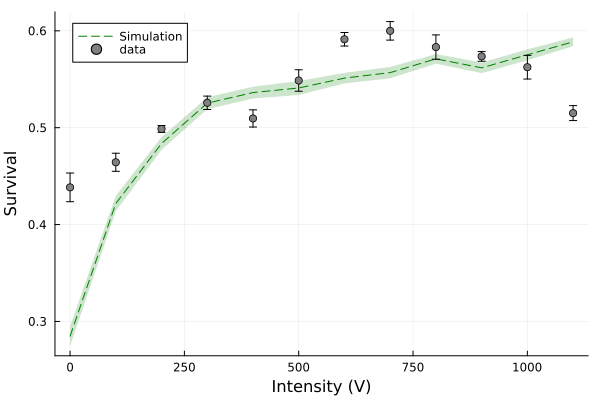

In [10]:
signals = []
signal_errors = []

for results in results_list[1:end]
    signal, error = bootstrap_survival(results, iter=100)
    push!(signals, signal)
    push!(signal_errors, error)
end
    
plot(voltages, signals,color="green", linestyle=:dash, xlabel="Intensity (V)", ylabel="Survival",label="Simulation",
ribbon=(signal_errors, signal_errors),fc=:green,fa=0.2)



# signals1 = []
# signal1_errors = []
# for results in results_list_imperfection[1:end]
#     signal1, error = bootstrap_survival(results; iter=100)
#     push!(signals1, signal1)
#     push!(signal1_errors, error)
# end

# plot!(voltages, signals1,color="red",linestyle=:dash, label="Simulation with imperfection",
# ribbon=(signal1_errors, signal1_errors),fc=:red,fa=0.2)


# signals2 = []
# signal2_errors = []
# for results in results_list_imperfection1[1:end]
#     signal1, error = bootstrap_survival(results; iter=100)
#     push!(signals2, signal1)
#     push!(signal2_errors, error)
# end

# plot!(voltages, signals2,color="blue",linestyle=:dash, label="Simulation with imperfection",
# ribbon=(signal1_errors, signal1_errors),fc=:blue,fa=0.2)


scatter!(voltages, data_signal./maximum(data_signal)*0.6, yerr=d_data_signal, color="gray", label="data")

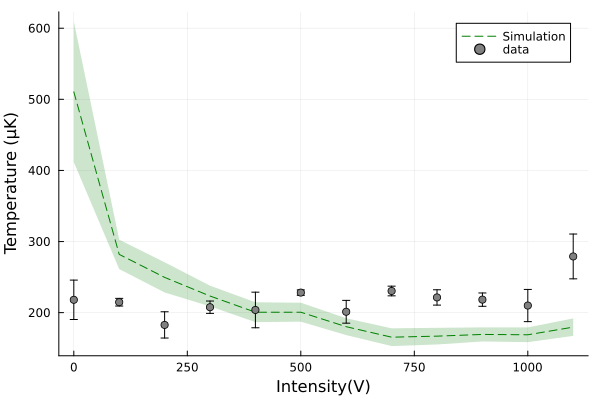

In [12]:
temperatures = []
temperature_errors = []
t_end = 5e-3

for results in results_list[1:end]
    temp, error = bootstrap_temperature_fit(results, iter=100)
    push!(temperatures, temp)
    push!(temperature_errors, error)
end
    
plot(voltages, temperatures,color="green",linestyle=:dash, xlabel="Intensity(V)", ylabel="Temperature (μK)",label="Simulation",
ribbon=(temperature_errors, temperature_errors),fc=:green,fa=0.2)



# temperatures1 = []
# temperature1_errors = []
# for results in results_list_imperfection[1:end]
#     temp, error = bootstrap_temperature_fit(results; iter=100)
#     push!(temperatures1, temp)
#     push!(temperature1_errors, error)
# end

# plot!(voltages, temperatures1,color="red",linestyle=:dash, label="Simulation with imperfection",
# ribbon=(temperature1_errors, temperature1_errors),fc=:red,fa=0.2)


# temperatures2 = []
# temperature2_errors = []
# for results in results_list_imperfection1[1:end]
#     temp, error = bootstrap_temperature_fit(results; iter=100)
#     push!(temperatures2, temp)
#     push!(temperature2_errors, error)
# end

# plot!(voltages, temperatures2,color="blue",linestyle=:dash, label="Simulation with more imperfection",
# ribbon=(temperature1_errors, temperature1_errors),fc=:blue,fa=0.2)



scatter!(voltages, data_temperature.*1e6, yerr=d_data_temperature.*1e6, color="gray", label="data")

In [13]:
file = matopen(simulation_file_path, "w")
write(file, "simulation_sizes", sizes)
write(file, "simulation_size_errors", size_errors)

write(file, "simulation_signals", signals)
write(file, "simulation_signal_errors", signal_errors)

write(file, "simulation_temperatures", temperatures)
write(file, "simulation_temperature_errors", temperature_errors)

# write(file, "simulation_sizes_imperfection", sizes1)
# write(file, "simulation_size_errors_imperfection", size1_errors)

# write(file, "simulation_signals_imperfection", signals1)
# write(file, "simulation_signal_errors_imperfection", signal1_errors)

# write(file, "simulation_temperatures_imperfection", temperatures1)
# write(file, "simulation_temperature_errors_imperfection", temperature1_errors)
close(file);